In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import pickle
import scipy.ndimage
import nibabel as nib
import nibabel.processing
from nilearn import datasets, plotting, image
from medpy.io import load
from IPython.display import Image

import tifffile as tiff
from tifffile import imsave
from libtiff import TIFF

#------3D-imports
import keras
from keras import metrics
from functools import partial
from keras import backend as K
from keras.layers import Input, LeakyReLU, Add, Activation, SpatialDropout3D
from keras.optimizers import Adam, RMSprop
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Deconvolution3D, GlobalAveragePooling3D
from keras.layers import Activation, BatchNormalization, Flatten, Dense, PReLU

# K.set_image_dim_ordering('th')
# K.set_image_dim_ordering('tf')
keras.backend.image_data_format()
K.set_image_data_format('channels_first')

try:
    from keras.engine import merge
except ImportError:
    from keras.layers.merge import concatenate
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(len(device_lib.list_local_devices()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11736644750562052621
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13977796181222805974
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
2


In [2]:
from nilearn.image.image import check_niimg
from nilearn.image.image import _crop_img_to as crop_img_to


def crop_img(img, rtol=1e-8, copy=True, return_slices=False):
    img = check_niimg(img)
    data = img.get_data()
    infinity_norm = max(-data.min(), data.max())
    passes_threshold = np.logical_or(data < -rtol * infinity_norm,
                                     data > rtol * infinity_norm)

    if data.ndim == 4:
        passes_threshold = np.any(passes_threshold, axis=-1)
    coords = np.array(np.where(passes_threshold))
    start = coords.min(axis=1)
    end = coords.max(axis=1) + 1

    # pad with one voxel to avoid resampling problems
    start = np.maximum(start - 1, 0)
    end = np.minimum(end + 1, data.shape[:3])

    slices = [slice(s, e) for s, e in zip(start, end)]

    if return_slices:
        return slices

    return crop_img_to(img, slices, copy=copy)

In [3]:
T1c_path = './data/CBICA_T1c.nii.gz'
segpath = './data/CBICA_OT.nii.gz'

T1c = nibabel.load(T1c_path)
OT = nibabel.load(segpath)
T1c_cropped = crop_img(T1c)
OT_cropped = crop_img(OT)
print(T1c.shape, T1c_cropped.shape)
print(OT.shape, OT_cropped.shape)

(240, 240, 155) (148, 179, 142)
(240, 240, 155) (101, 88, 84)


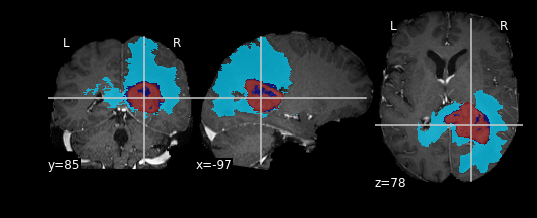

In [9]:
plotting.plot_roi(OT, bg_img=T1c, cmap='jet', dim=-.5)

In [16]:
HGG_dir_list = next(os.walk('./BRATS18_Training/HGG/'))[1]
# print(len(HGG_dir_list))
LGG_dir_list = next(os.walk('./BRATS18_Training/LGG/'))[1]
# print(len(LGG_dir_list))
valid_list = next(os.walk('./BRATS18_Validation/'))[1]
completelist = HGG_dir_list + LGG_dir_list

tumor_type_dict = {}

for patientID in completelist:
    if patientID in HGG_dir_list:
        tumor_type_dict[patientID] = 0
    elif patientID in LGG_dir_list:
        tumor_type_dict[patientID] = 1
labels={}
for directory in HGG_dir_list:
    labels[directory]=0
for directory in LGG_dir_list:
    labels[directory]=1  

partition={}
partition['holdout']=valid_list

In [11]:
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def weighted_dice_coefficient(y_true, y_pred, axis=(-3, -2, -1), smooth=0.00001):
    return K.mean(2.*(K.sum(y_true*y_pred,axis=axis)+smooth/2)/(K.sum(y_true,axis=axis)+K.sum(y_pred,axis=axis)+smooth))

def weighted_dice_coefficient_loss(y_true, y_pred):
    return -weighted_dice_coefficient(y_true, y_pred)

def label_wise_dice_coefficient(y_true, y_pred, label_index):
    return dice_coefficient(y_true[:, label_index], y_pred[:, label_index])

def get_label_dice_coefficient_function(label_index):
    f = partial(label_wise_dice_coefficient, label_index=label_index)
    f.__setattr__('__name__', 'label_{0}_dice_coef'.format(label_index))
    return f

def mean_iou(y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)

dice_coef = dice_coefficient
dice_coef_loss = dice_coefficient_loss

In [12]:
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# model1 = load_model('./model/model_1.hdf5')
model2 = keras.models.load_model('./model/model_2.hdf5',
              custom_objects={'InstanceNormalization':InstanceNormalization,
                              'weighted_dice_coefficient_loss': weighted_dice_coefficient_loss,
                              'weighted_dice_coefficient': weighted_dice_coefficient,
                              'dice_coefficient': dice_coefficient,
                              'dice_coefficient_loss': dice_coefficient_loss,
                              })
model2.load_weights("./weights/model_2_weights.h5")
model2.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 80, 96, 80 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 12, 80, 96, 8 1308        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization_1 (Insta (None, 12, 80, 96, 8 24          conv3d_1[0][0]                   
_______________________________________________________

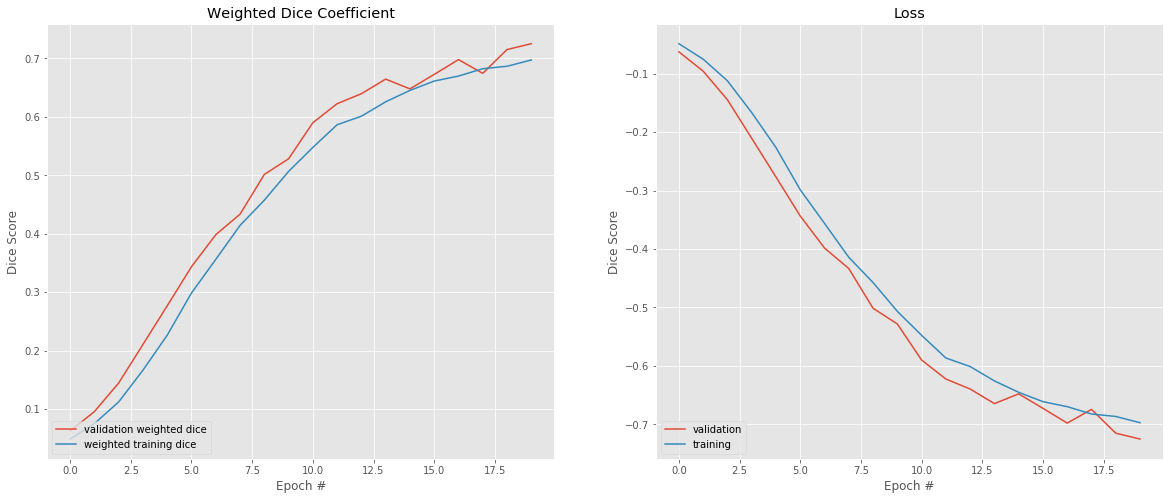

In [17]:
history_2_pred = results.history
pickle.dump( history_2_pred, open( "./weights/history_2_pred.pkl", "wb" ) )

plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))
titlemetric = ['Weighted Dice Coefficient', 'Loss']

for i in range(1,3):
    fig.add_subplot(1,2,i)
    plt.title(titlemetric[i-1])
    if(i-1==0):
        plt.plot(history_2_pred['val_weighted_dice_coefficient'], label='validation weighted dice')
        plt.plot(history_2_pred['weighted_dice_coefficient'], label = 'weighted training dice')
    else:
        plt.plot(history_2_pred['val_loss'], label='validation')
        plt.plot(history_2_pred['loss'], label = 'training')
    plt.xlabel("Epoch #")
    plt.ylabel("Dice Score")
    plt.legend(loc="lower left")

# Cutoff
From here the code had to be hidden due to concerns. It may be released at a later date.

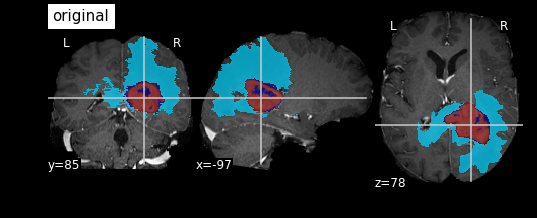

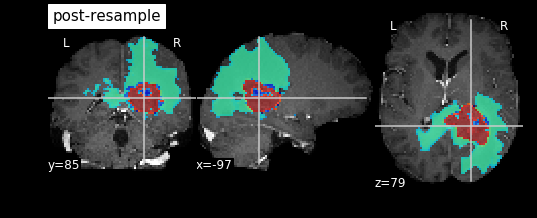

In [27]:
#Edits done here due to privacy concerns
after0 = nibabel.processing.resample_to_output(T1c, [2,2,2])
after1 = nibabel.processing.resample_to_output(OT, [2,2,2])
smoothafter = image.smooth_img(after1, fwhm=2)

plotting.plot_roi(OT, bg_img=T1c, cmap='jet', dim=-.5, title='original')
plotting.plot_roi(smoothafter, bg_img=after0, cmap='jet', dim=-.5, title='post-resample/smooth')